<a href="https://colab.research.google.com/github/kzumreen/FoodTrendsPrediction/blob/main/pytrends_worldwide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTrends EDA Template

This notebook pulls Google Trends data via **PyTrends** (or uses synthetic data if offline), performs exploratory data analysis (descriptive statistics + visualizations), and saves outputs. It is designed to satisfy the EDA rubric for your DAT 490 project.

## Setup

Install required packages (run in terminal):

```bash
pip install pytrends pandas matplotlib seaborn plotly nbformat
```

If pytrends or network access is unavailable, the notebook falls back to a synthetic dataset for demonstration.

In [ ]:
# Optional: install packages from the notebook
# !pip install pytrends pandas matplotlib seaborn plotly nbformat


In [1]:
!pip install pytrends pandas matplotlib seaborn plotly nbformat

In [2]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime
OUTPUT_DIR = 'pytrends_eda_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)
sns.set(style='whitegrid')


In [3]:
def synthetic_trends(keywords, start='2021-01-01', end='2025-10-01', seed=42):
    rng = pd.date_range(start=start, end=end, freq='W-SUN')
    np.random.seed(seed)
    data = pd.DataFrame(index=rng)
    for kw in keywords:
        base = np.random.poisson(lam=5, size=len(rng)).astype(float)
        spikes = np.zeros(len(rng))
        for i in range(3):
            loc = np.random.randint(0, len(rng))
            width = np.random.randint(1, 6)
            height = np.random.randint(30, 90)
            start_i = max(0, loc - width)
            end_i = min(len(rng), loc + width)
            spikes[start_i:end_i] += np.linspace(height, 0, end_i-start_i)
        series = (base + spikes).clip(0, 100)
        series = (series / series.max() * 100) if series.max() > 0 else series
        data[kw] = series.round(1)
    return data

def descriptive_stats(df):
    stats = df.describe().T
    stats['skew'] = df.skew()
    stats['kurtosis'] = df.kurtosis()
    return stats

def save_fig(fig, name):
    out = os.path.join(OUTPUT_DIR, name)
    fig.savefig(out, dpi=150, bbox_inches='tight')
    print('Saved', out)


## Fetch Google Trends Data
Edit `keywords`, `timeframe`, `geo`, and `gprop` below. If pytrends is unavailable, the notebook will use synthetic data.

In [4]:
keywords = ['matcha', 'baked feta cheese pasta', 'dubai chocolate']
timeframe = '2015-01-01 2025-10-01'
geo = ''
gprop = ''

def fetch_google_trends(keywords, timeframe='2021-01-01 2025-10-01', geo='US', gprop=''):
    try:
        from pytrends.request import TrendReq
    except Exception as e:
        print('pytrends import failed:', e)
        return None
    try:
        pytrends = TrendReq(hl='en-US', tz=360)
        pytrends.build_payload(kw_list=keywords, timeframe=timeframe, geo=geo, gprop=gprop)
        data = pytrends.interest_over_time()
        if data is None or data.empty:
            return None
        if 'isPartial' in data.columns:
            data = data.drop(columns=['isPartial'])
        return data
    except Exception as e:
        print('pytrends fetch error:', e)
        return None

data = fetch_google_trends(keywords, timeframe=timeframe, geo=geo, gprop=gprop)
source = 'pytrends' if data is not None else 'synthetic'
if data is None:
    data = synthetic_trends(keywords, start=timeframe.split()[0], end=timeframe.split()[1])
print('Data source:', source)
data.head()


Data source: pytrends


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,matcha,baked feta cheese pasta,dubai chocolate
date,,,
2015-01-01,6,0,0
2015-02-01,7,0,0
2015-03-01,8,0,0
2015-04-01,10,0,0
2015-05-01,9,0,0


## Descriptive Statistics

In [5]:
stats = descriptive_stats(data)
stats


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
matcha,130.0,24.207692,18.906828,6.0,13.0,18.5,27.5,100.0,2.311659,5.347195
baked feta cheese pasta,130.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
dubai chocolate,130.0,2.207692,6.464808,0.0,0.0,0.0,0.0,35.0,3.231898,10.206377


In [6]:
print("Full DataFrame shape:", data.shape)

Full DataFrame shape: (130, 3)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130 entries, 2015-01-01 to 2025-10-01
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   matcha                   130 non-null    int64
 1   baked feta cheese pasta  130 non-null    int64
 2   dubai chocolate          130 non-null    int64
dtypes: int64(3)
memory usage: 4.1 KB


In [12]:
# --- Dataset Summary Utility ---
import pandas as pd
import numpy as np

def dataset_summary(df, name="Dataset"):

    # Shape and basic info
    print(f"\nShape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"Date Range: {df.index.min()} → {df.index.max()}" if isinstance(df.index, pd.DatetimeIndex) else "")

    # Column overview
    print("\nColumns:")
    for i, col in enumerate(df.columns, 1):
        non_null = df[col].notna().sum()
        dtype = df[col].dtype
        print(f"  {i:>2}. {col:35} | Non-null: {non_null:5d} | Dtype: {dtype}")

    # Missing value analysis
    print("\nMissing Value Summary:")
    missing = df.isna().mean().sort_values(ascending=False)
    if missing.sum() == 0:
        print("  ✅ No missing values detected.")
    else:
        print(missing.apply(lambda x: f"{x*100:.2f}%").to_string())

    # Basic descriptive statistics (numeric columns)
    print("\nDescriptive Statistics:")
    display(df.describe().T.round(2))
    print("="*100 + "\n")

# --- Example usage ---
# assuming your data DataFrame is named `data`
dataset_summary(data, name="PyTrends Google Trends Data")



Shape: 130 rows × 3 columns
Date Range: 2015-01-01 00:00:00 → 2025-10-01 00:00:00

Columns:
   1. matcha                              | Non-null:   130 | Dtype: int64
   2. baked feta cheese pasta             | Non-null:   130 | Dtype: int64
   3. dubai chocolate                     | Non-null:   130 | Dtype: int64

Missing Value Summary:
  ✅ No missing values detected.

Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
matcha,130.0,24.21,18.91,6.0,13.0,18.5,27.5,100.0
baked feta cheese pasta,130.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
dubai chocolate,130.0,2.21,6.46,0.0,0.0,0.0,0.0,35.0


## Time-series Plot

Saved pytrends_eda_outputs/fig_time_series_matcha.png


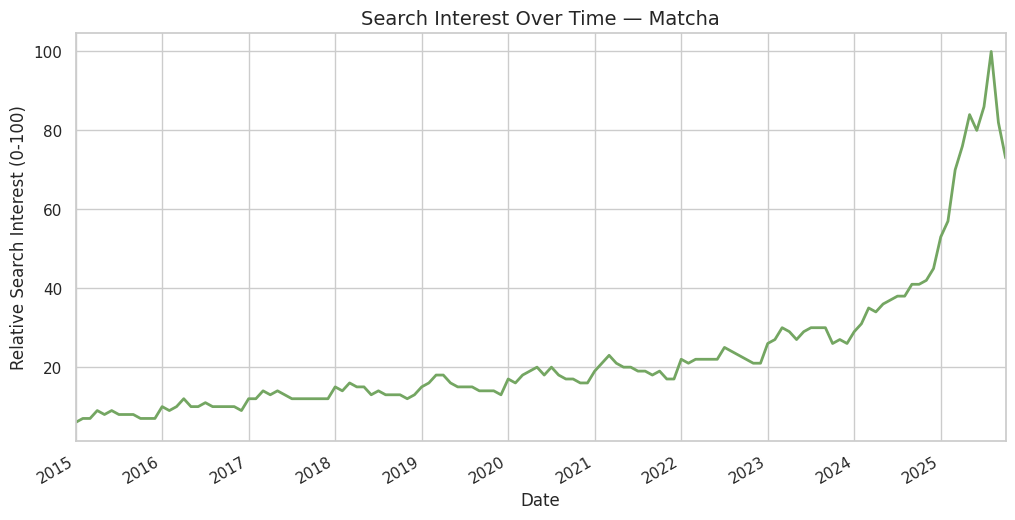

In [14]:
#Matcha Time Series Plot
fig, ax = plt.subplots(figsize=(12,6))
data['matcha'].plot(ax=ax, color='#74A662', linewidth=2)
ax.set_title("Search Interest Over Time — Matcha", fontsize=14)
ax.set_ylabel("Relative Search Interest (0-100)")
ax.set_xlabel("Date")
fig.autofmt_xdate()
save_fig(fig, "fig_time_series_matcha.png")
plt.show()


Saved pytrends_eda_outputs/fig_time_series_dubai_chocolate.png


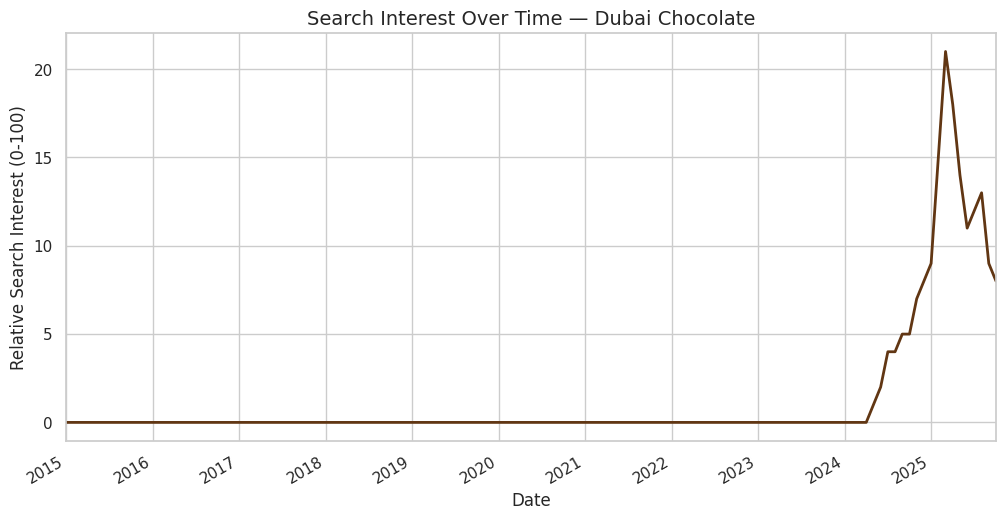

In [9]:
#Dubai Chocolate Time Series Plot
fig, ax = plt.subplots(figsize=(12,6))
data['dubai chocolate'].plot(ax=ax, color='#613613', linewidth=2)
ax.set_title("Search Interest Over Time — Dubai Chocolate", fontsize=14)
ax.set_ylabel("Relative Search Interest (0-100)")
ax.set_xlabel("Date")
fig.autofmt_xdate()
save_fig(fig, "fig_time_series_dubai_chocolate.png")
plt.show()

Saved pytrends_eda_outputs/fig_time_series_baked_feta_cheese_pasta.png


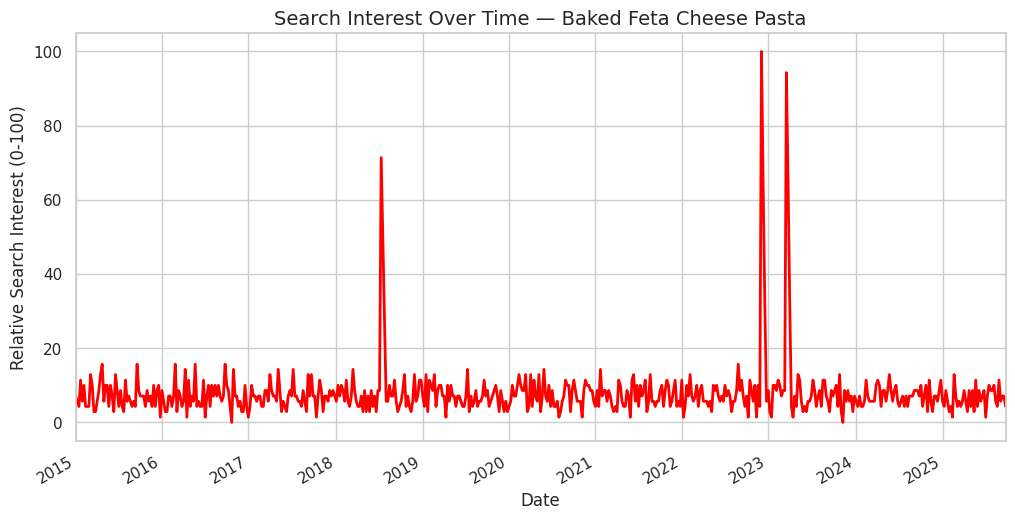

In [ ]:
#Baked Feta Cheese Pasta Time Series Plot
fig, ax = plt.subplots(figsize=(12,6))
data['baked feta cheese pasta'].plot(ax=ax, color='red', linewidth=2)
ax.set_title("Search Interest Over Time — Baked Feta Cheese Pasta", fontsize=14)
ax.set_ylabel("Relative Search Interest (0-100)")
ax.set_xlabel("Date")
fig.autofmt_xdate()
save_fig(fig, "fig_time_series_baked_feta_cheese_pasta.png")
plt.show()

## Rolling Mean (8-week)

Saved pytrends_eda_outputs/fig_rolling_8w_matcha.png


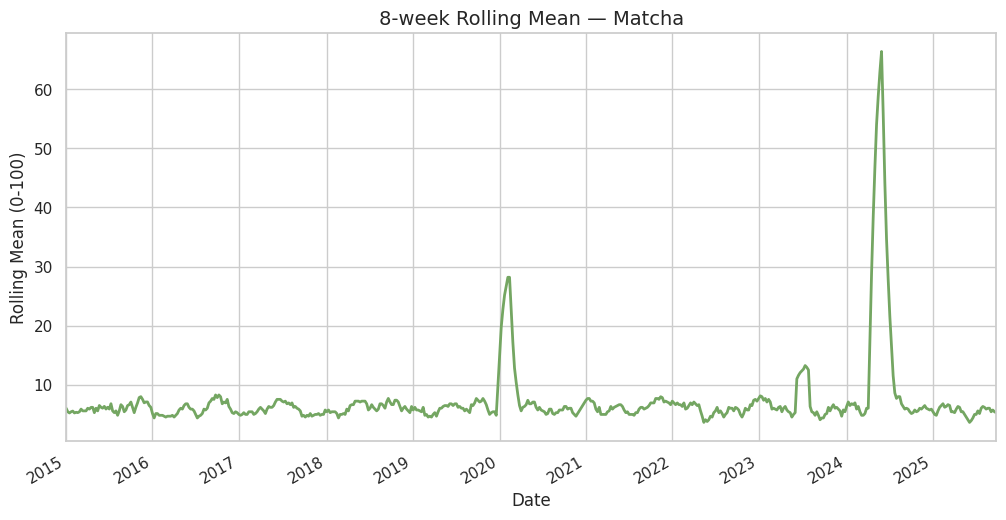

In [ ]:
# Rolling Mean - Matcha
fig, ax = plt.subplots(figsize=(12,6))
data['matcha'].rolling(window=8, min_periods=1).mean().plot(ax=ax, color='#74A662', linewidth=2)
ax.set_title("8-week Rolling Mean — Matcha", fontsize=14)
ax.set_ylabel("Rolling Mean (0-100)")
ax.set_xlabel("Date")
fig.autofmt_xdate()
save_fig(fig, "fig_rolling_8w_matcha.png")
plt.show()


Saved pytrends_eda_outputs/fig_rolling_8w_dubai_chocolate.png


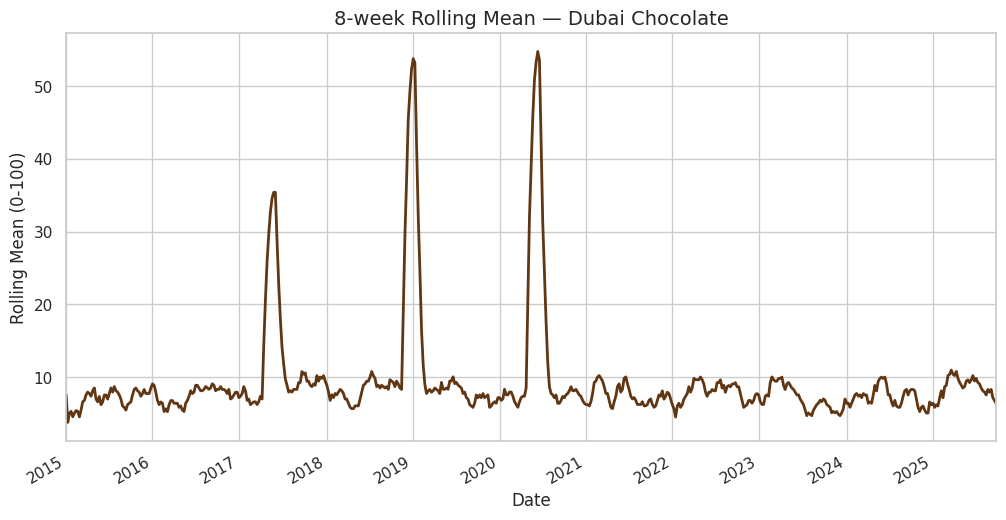

In [ ]:
# Rolling Mean - Dubai Chocolate
fig, ax = plt.subplots(figsize=(12,6))
data['dubai chocolate'].rolling(window=8, min_periods=1).mean().plot(ax=ax, color='#613613', linewidth=2)
ax.set_title("8-week Rolling Mean — Dubai Chocolate", fontsize=14)
ax.set_ylabel("Rolling Mean (0-100)")
ax.set_xlabel("Date")
fig.autofmt_xdate()
save_fig(fig, "fig_rolling_8w_dubai_chocolate.png")
plt.show()

Saved pytrends_eda_outputs/fig_rolling_8w_baked_feta_cheese_pasta.png


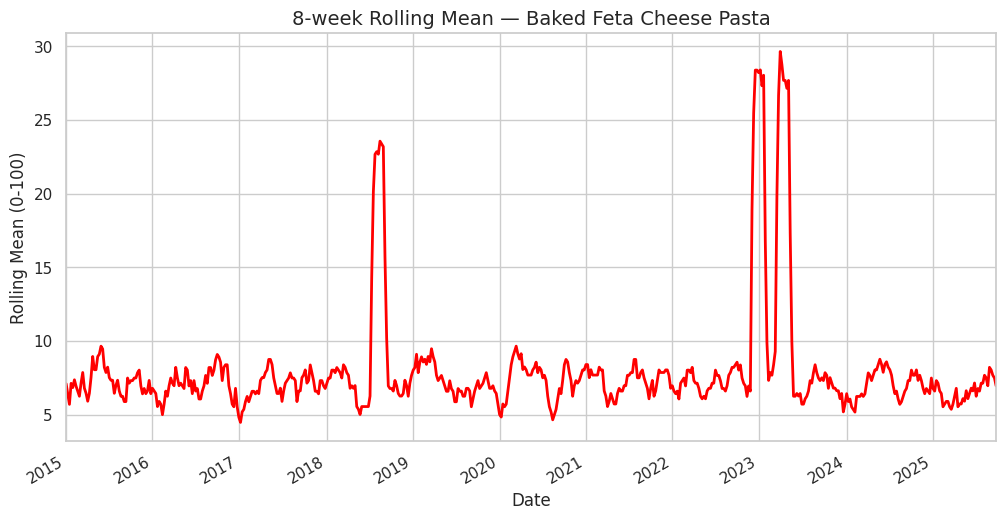

In [ ]:
# Rolling Mean - Baked Feta Cheese Pasta
fig, ax = plt.subplots(figsize=(12,6))
data['baked feta cheese pasta'].rolling(window=8, min_periods=1).mean().plot(ax=ax, color='red', linewidth=2)
ax.set_title("8-week Rolling Mean — Baked Feta Cheese Pasta", fontsize=14)
ax.set_ylabel("Rolling Mean (0-100)")
ax.set_xlabel("Date")
fig.autofmt_xdate()
save_fig(fig, "fig_rolling_8w_baked_feta_cheese_pasta.png")
plt.show()

## Correlation Heatmap

Saved pytrends_eda_outputs/fig_correlation.png


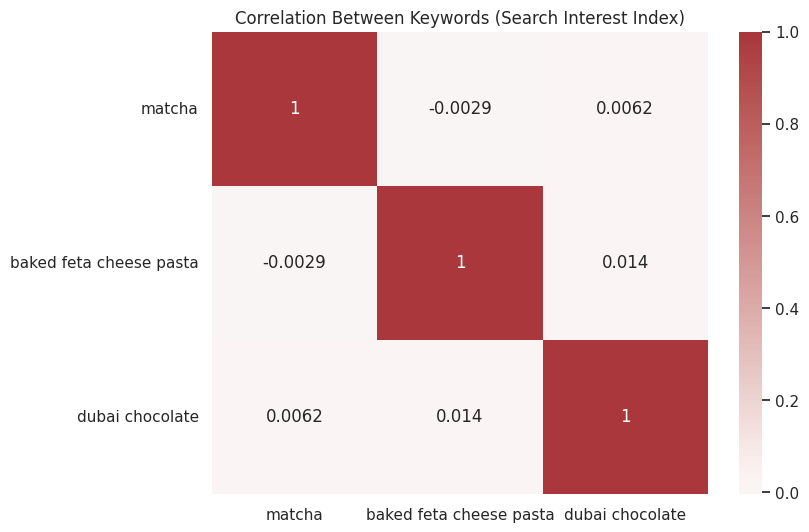

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap='vlag', center=0, ax=ax)
ax.set_title('Correlation Between Keywords (Search Interest Index)')
save_fig(fig, 'fig_correlation.png')
plt.show()


In [15]:
# CHOROPLETH: Regional Popularity for each keyword
# Requires: pytrends, plotly
# Install in Colab if needed: !pip install plotly pytrends

import os
import pandas as pd
import numpy as np
import plotly.express as px

OUTDIR = OUTPUT_DIR if 'OUTPUT_DIR' in globals() else "pytrends_eda_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# keywords list used in your notebook; adjust if necessary
try:
    keywords
except NameError:
    keywords = ['matcha','baked_feta_cheese_pasta','dubai_chocolate','air_fryer']

# helper to normalize keywords to pytrends-friendly (spaces -> single space)
def pretty_kw(k):
    return k.replace('_',' ')

# Attempt to use pytrends to get interest_by_region for each keyword (best coverage)
use_pytrends = True
try:
    from pytrends.request import TrendReq
    pytrends = TrendReq(hl='en-US', tz=360)
except Exception:
    use_pytrends = False
    print("pytrends not available — will try fallback to existing data columns.")

for kw in keywords:
    pretty = pretty_kw(kw)
    df_country = None

    if use_pytrends:
        try:
            # pytrends wants 1 keyword at a time for interest_by_region
            pytrends.build_payload([pretty], timeframe=timeframe if 'timeframe' in globals() else '2015-01-01 2025-10-01', geo='', gprop='')
            df_region = pytrends.interest_by_region(resolution='COUNTRY', inc_low_vol=True, inc_geo_code=True)
            # df_region index is country names; columns include keyword and possibly 'geoCode'
            if df_region is not None and not df_region.empty:
                # ensure column name matches pretty
                # sometimes pytrends returns the query string as column
                col_name = df_region.columns[0]
                tmp = df_region.reset_index().rename(columns={'geoCode':'geoCode', col_name: 'value'})
                # keep geoCode (alpha-2) and country name
                if 'geoCode' in tmp.columns:
                    df_country = tmp[['geoCode','region','value']].rename(columns={'region':'country','geoCode':'iso2'})
                else:
                    # fallback: no geoCode, use region name and value
                    df_country = tmp[['region','value']].rename(columns={'region':'country','value':'value'})
        except Exception as e:
            print(f"pytrends interest_by_region failed for '{pretty}': {e}")
            df_country = None

    # Fallback: check for columns in merged data like kw_* (e.g., matcha_US)
    if df_country is None:
        # gather any columns starting with kw (underscores and spaces normalized)
        pattern = kw.lower()
        cols = [c for c in data.columns if c.lower().startswith(pattern)]
        if len(cols) > 0:
            # each column is country-specific; compute mean across time per column and try to map suffix -> iso2
            records = []
            for c in cols:
                meanv = data[c].mean(skipna=True)
                # try to grab suffix after last underscore as code
                suffix = c.split('_')[-1].upper()
                records.append({'iso2': suffix if len(suffix)==2 else None, 'country': c, 'value': meanv})
            df_country = pd.DataFrame(records)
        else:
            print(f"No country-level data available for '{kw}'. Skipping choropleth.")
            continue

    # For Plotly we prefer ISO-3 codes; convert iso2 -> iso3 where possible
    # try mapping iso2 to iso3 via pycountry (optional)
    try:
        import pycountry
        def iso2_to_iso3(code):
            try:
                return pycountry.countries.get(alpha_2=code).alpha_3
            except Exception:
                return None
        if 'iso2' in df_country.columns:
            df_country['iso2'] = df_country['iso2'].astype(str)
            df_country['iso3'] = df_country['iso2'].apply(lambda x: iso2_to_iso3(x) if pd.notna(x) and x not in ['nan','None'] else None)
            # where iso3 missing, maybe country names present: try lookup by name
            df_country.loc[df_country['iso3'].isna(), 'iso3'] = df_country.loc[df_country['iso3'].isna(), 'country'].apply(
                lambda n: (pycountry.countries.get(name=n).alpha_3 if pycountry.countries.get(name=n) else None) if pd.notna(n) else None
            )
        else:
            # try to map by country name
            df_country['iso3'] = df_country['country'].apply(lambda n: (pycountry.countries.get(name=n).alpha_3 if pycountry.countries.get(name=n) else None) if pd.notna(n) else None)
    except Exception:
        # If pycountry not installed, try a simple mapping for common codes (US, GB, IN, AE, KR)
        map2 = {'US':'USA','GB':'GBR','IN':'IND','AE':'ARE','KR':'KOR'}
        if 'iso2' in df_country.columns:
            df_country['iso3'] = df_country['iso2'].map(map2)
        else:
            df_country['iso3'] = None

    # drop NaN iso3 rows (Plotly needs iso3)
    df_plot = df_country.dropna(subset=['iso3']).copy()

    if df_plot.empty:
        print(f"No mappable country codes for '{kw}'. Skipping.")
        continue

    # normalize values to 0-100 (optional): but Google Trends already in 0-100 per query
    # create choropleth
    fig = px.choropleth(df_plot,
                        locations='iso3',
                        color='value',
                        hover_name='country',
                        color_continuous_scale='Greens' if 'matcha' in kw else ('Reds' if 'feta' in kw or 'feta' in pretty else 'Oranges'),
                        title=f"Regional Popularity: {pretty.title()}",
                        labels={'value':'Avg Interest'})
    html_out = os.path.join(OUTDIR, f"choropleth_{kw}.html")
    fig.write_html(html_out)
    print(f"Saved choropleth for '{pretty}' to {html_out}")
    fig.show()

pytrends interest_by_region failed for 'matcha': "['region'] not in index"
No mappable country codes for 'matcha'. Skipping.
pytrends interest_by_region failed for 'baked feta cheese pasta': "['region'] not in index"
No mappable country codes for 'baked feta cheese pasta'. Skipping.
pytrends interest_by_region failed for 'dubai chocolate': "['region'] not in index"
No mappable country codes for 'dubai chocolate'. Skipping.
